In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER


In [2]:
import matplotlib.pyplot as plt
from functools import partial
from jax_tqdm import scan_tqdm

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly

from plotly_resampler import register_plotly_resampler, FigureWidgetResampler

import pandas as pd

from algorithms.utils import restore_state

import numpy as np

import jax
import jax.numpy as jnp
# jax.config.update("jax_enable_x64", True)

2025-03-01 14:30:41.118538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740835841.132895  179378 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740835841.137017  179378 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from ernestogym.envs_jax.single_agent.env import MicroGridEnv
from ernestogym.envs_jax.single_agent.env_trading_soc import MicroGridEnvSocAction

In [4]:
def my_env_creator(params, battery_type, env_type='normal'):
    if env_type == 'normal':
        env = MicroGridEnv(params, battery_type)
    elif env_type == 'soc_action':
        env = MicroGridEnvSocAction(params, battery_type)
    else:
        raise ValueError('Unknown env_type')
    return env, env.params

In [5]:
from ernestogym.envs_jax.single_agent.utils import parameter_generator

In [6]:
pack_options = "ernestogym/ernesto_jax/data/battery_new/pack.yaml"
ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_pack.yaml"
# ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_fading_pack.yaml"
r2c = "ernestogym/ernesto_jax/data/battery_new/models/thermal/r2c_thermal_pack.yaml"
# bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
world = "ernestogym/envs_jax/single_agent/ijcnn_deg_test.yaml"
# world = "ernestogym/envs_jax/single_agent/world_fading.yaml"

# battery_type = 'fading'
# battery_type = 'degrading'
battery_type = 'degrading_dropflow'

params = parameter_generator(
    input_var='current',
    battery_options=pack_options,
    electrical_model=ecm,
    thermal_model=r2c,
    aging_model=bolun,
    world_options=world,
    use_reward_normalization=True

)

env_type = 'normal'
num_iter = 8760 * 28

params['step']

3600

# Testing

In [7]:
logs = {}

## PPO

In [8]:
@partial(jax.jit, static_argnums=(0, 2, 3))
def test_ppo(env: MicroGridEnv, env_params, network, num_iter, rng):

    rng, _rng = jax.random.split(rng)

    env_params = env.eval(env_params)

    obsv, env_state = env.reset(_rng, env_params)

    env_params = env_params.replace(test_profile=env_params.test_profile+1)

    @scan_tqdm(num_iter, print_rate=num_iter // 100)
    def _env_step(runner_state, unused):
        obsv, env_state, env_params, rng = runner_state

        pi, _ = network(obsv)

        #deterministic action
        action = pi.mode()

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward, done, info = env.step(_rng, env_state, action, env_params)

        env_params = jax.lax.cond(done,
                                  lambda : env_params.replace(test_profile=env_params.test_profile+1),
                                  lambda : env_params)

        runner_state = (obsv, env_state, env_params, rng)
        return runner_state, (info, action)

    runner_state = (obsv, env_state, env_params, rng)

    runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))

    return info

In [9]:
directory = '/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER/trained_agents/20250227_222830_lr_0.001_tot_timesteps_3504000_anneal_rl_True_normal_actor_critic'

network, config, params_training, val_info = restore_state(directory)

assert config['ENV_TYPE'] == env_type

In [10]:
config

FrozenDict({
    ACTION_SPACE_SIZE: 1,
    ACTIVATION: 'swish',
    ANNEAL_LR: True,
    CLIP_EPS: 0.2,
    DEBUG: False,
    ENT_COEF: 0.01,
    ENV_NAME: None,
    ENV_TYPE: 'normal',
    GAE_LAMBDA: 0.95,
    GAMMA: 0.99,
    LOGISTIC_FUNCTION_TO_ACTOR: False,
    LR: 0.001,
    MAX_GRAD_NORM: 0.5,
    MINIBATCH_SIZE: 1024,
    NETWORK: 'actor_critic',
    NET_ARCH: (32, 16, 8),
    NORMALIZE_ADVANTAGES: True,
    NORMALIZE_ENV: False,
    NUM_ENVS: 4,
    NUM_MINIBATCHES: 32,
    NUM_STEPS: 8192,
    NUM_UPDATES: 106,
    OBSERVATION_SPACE_SIZE: 10,
    TOTAL_TIMESTEPS: 3504000,
    UPDATE_EPOCHS: 10,
    VF_COEF: 0.5,
})

In [11]:
env, env_params = my_env_creator(params, battery_type, env_type=env_type)
env_params = env.eval(env_params)

print(env.dem_matrix.shape)

(28, 8760)


In [12]:
info, actions = test_ppo(env, env_params, network, num_iter, jax.random.PRNGKey(51))
info['actions'] = actions.flatten()
logs['ppo'] = info

Running for 245,280 iterations:   0%|          | 0/245280 [00:00<?, ?it/s]

## Recurrent PPO

In [13]:
# @partial(jax.jit, static_argnums=(0, 2, 3))
def test_recurrent_ppo(env: MicroGridEnv, env_params, network, num_iter, rng):

    rng, _rng = jax.random.split(rng)

    env_params = env.eval(env_params)

    obsv, env_state = env.reset(_rng, env_params)

    env_params = env_params.replace(test_profile=env_params.test_profile+1)

    act_state, cri_state = network.get_initial_lstm_state()

    act_state, cri_state = jax.tree.map(lambda x : jnp.astype(x, float), (act_state, cri_state))    # cast to float64 if 'jax_enable_x64' is enabled

    @scan_tqdm(num_iter, print_rate=num_iter // 100)
    def _env_step(runner_state, unused):

        obsv, env_state, env_params, act_state, rng = runner_state

        pi, _, act_state, _ = network(obsv, act_state, cri_state)

        #deterministic action
        action = pi.mode()

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward, done, info = env.step(_rng, env_state, action, env_params)

        env_params = jax.lax.cond(done,
                                  lambda : env_params.replace(test_profile=env_params.test_profile+1),
                                  lambda : env_params)

        runner_state = (obsv, env_state, env_params, act_state, rng)
        return runner_state, (info, action)

    runner_state = (obsv, env_state, env_params, act_state, rng)


    runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))

    return info

In [14]:
directory = '/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER/trained_agents/20250227_144145_lr_0.001_tot_timesteps_3504000_anneal_rl_True_normal_recurrent_actor_critic'

network, config, params_training, val_info = restore_state(directory)

assert config['ENV_TYPE'] == env_type

In [15]:
config

FrozenDict({
    ACTION_SPACE_SIZE: 1,
    ACTIVATION: 'relu',
    ANNEAL_LR: True,
    CLIP_EPS: 0.2,
    DEBUG: False,
    ENT_COEF: 0.01,
    ENV_NAME: None,
    ENV_TYPE: 'normal',
    GAE_LAMBDA: 0.95,
    GAMMA: 0.99,
    LOGISTIC_FUNCTION_TO_ACTOR: False,
    LR: 0.001,
    LSTM_ACTIVATION: 'tanh',
    LSTM_NET_ARCH: (16,),
    MAX_GRAD_NORM: 0.5,
    MINIBATCH_SIZE: 256,
    NETWORK: 'recurrent_actor_critic',
    NET_ARCH: (32, 32),
    NORMALIZE_ADVANTAGES: True,
    NORMALIZE_ENV: False,
    NUM_ENVS: 4,
    NUM_MINIBATCHES: 128,
    NUM_SEQUENCES: 6,
    NUM_STEPS: 8192,
    NUM_UPDATES: 106,
    OBSERVATION_SPACE_SIZE: 10,
    TOTAL_TIMESTEPS: 3504000,
    UPDATE_EPOCHS: 10,
    VF_COEF: 0.5,
})

In [16]:
info, actions = test_recurrent_ppo(env, env_params, network, num_iter, jax.random.PRNGKey(51))
info['actions'] = actions.flatten()
logs['recurrent_ppo'] = info

Running for 245,280 iterations:   0%|          | 0/245280 [00:00<?, ?it/s]

## Random

In [17]:
@partial(jax.jit, static_argnums=(0, 2))
def test_random(env: MicroGridEnv, env_params, num_iter, rng):

    rng, _rng = jax.random.split(rng)

    env_params = env.eval(env_params)

    obsv, env_state = env.reset(_rng, env_params)

    env_params = env_params.replace(test_profile=env_params.test_profile+1)

    @scan_tqdm(num_iter, print_rate=num_iter // 100)
    def _env_step(runner_state, unused):
        obsv, env_state, env_params, rng = runner_state

        rng, _rng = jax.random.split(rng)
        action = jax.random.uniform(_rng, minval=env_params.i_min_action, maxval=env_params.i_max_action)

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward, done, info = env.step(_rng, env_state, action, env_params)

        env_params = jax.lax.cond(done,
                                  lambda : env_params.replace(test_profile=env_params.test_profile+1),
                                  lambda : env_params)

        runner_state = (obsv, env_state, env_params, rng)
        return runner_state, (info, action)

    runner_state = (obsv, env_state, env_params, rng)

    runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))

    return info

In [18]:
info, actions = test_random(env, env_params, num_iter, jax.random.PRNGKey(51))
info['actions'] = actions.flatten()
logs['random'] = info

Running for 245,280 iterations:   0%|          | 0/245280 [00:00<?, ?it/s]

## Only market

In [19]:
@partial(jax.jit, static_argnums=(0, 2))
def test_only_market(env: MicroGridEnv, env_params, num_iter, rng):

    rng, _rng = jax.random.split(rng)

    env_params = env.eval(env_params)

    obsv, env_state = env.reset(_rng, env_params)

    env_params = env_params.replace(test_profile=env_params.test_profile+1)

    @scan_tqdm(num_iter, print_rate=num_iter // 100)
    def _env_step(runner_state, unused):
        obsv, env_state, env_params, rng = runner_state

        action = 0.

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward, done, info = env.step(_rng, env_state, action, env_params)

        env_params = jax.lax.cond(done,
                                  lambda : env_params.replace(test_profile=env_params.test_profile+1),
                                  lambda : env_params)

        runner_state = (obsv, env_state, env_params, rng)
        return runner_state, (info, action)

    runner_state = (obsv, env_state, env_params, rng)

    runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))

    return info

In [20]:
info, actions = test_only_market(env, env_params, num_iter, jax.random.PRNGKey(51))
info['actions'] = actions.flatten()
logs['only_market'] = info

Running for 245,280 iterations:   0%|          | 0/245280 [00:00<?, ?it/s]

## Battery first

In [21]:
@partial(jax.jit, static_argnums=(0, 2))
def test_battery_first(env: MicroGridEnv, env_params, num_iter, rng):

    rng, _rng = jax.random.split(rng)

    env_params = env.eval(env_params)

    obsv, env_state = env.reset(_rng, env_params)

    env_params = env_params.replace(test_profile=env_params.test_profile+1)

    @scan_tqdm(num_iter, print_rate=num_iter // 100)
    def _env_step(runner_state, unused):
        obsv, env_state, env_params, rng = runner_state

        demand = obsv[env._obs_idx['demand']]
        generation = obsv[env._obs_idx['generation']]

        action = (generation - demand) / env_state.battery_state.electrical_state.v

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward, done, info = env.step(_rng, env_state, action, env_params)

        env_params = jax.lax.cond(done,
                                  lambda : env_params.replace(test_profile=env_params.test_profile+1),
                                  lambda : env_params)

        runner_state = (obsv, env_state, env_params, rng)
        return runner_state, (info, action)

    runner_state = (obsv, env_state, env_params, rng)

    runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))

    return info

In [22]:
info, actions = test_battery_first(env, env_params, num_iter, jax.random.PRNGKey(51))
info['actions'] = actions.flatten()
logs['battery_first'] = info

Running for 245,280 iterations:   0%|          | 0/245280 [00:00<?, ?it/s]

# Plotting

In [23]:
logs = jax.tree.map(lambda x : np.asarray(x), logs)

algs = ['random', 'only_market', 'battery_first', 'ppo', 'recurrent_ppo']
colors = {alg: col for alg, col in zip(algs, plotly.colors.sample_colorscale('rainbow', len(algs)))}

In [24]:
def plot_external_data_matplotlib(demand, generation, sell_prices, buy_prices, start=0, length_max=None):

    if length_max is None:
        length_max = max(len(demand), len(generation), len(sell_prices), len(buy_prices))

    fig = plt.figure(figsize=(15, 20))

    ax1 = fig.add_subplot(2, 1, 1)

    ax1.plot(demand[start:start + length_max], label='demand')
    ax1.plot(generation[start:start + length_max], label='generation')
    ax1.legend()
    ax1.set_ylabel('W')

    sell_prices *= 1000000
    buy_prices *= 1000000

    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(sell_prices[start:start + length_max], label='sell_price')
    ax2.plot(buy_prices[start:start + length_max], label='buy_price')
    ax2.legend()
    ax2.set_ylabel('€/MWh')

    plt.show()

# def plot_external_data_plotly(demand, generation, sell_prices, buy_prices, time_step):
#
#     n_points = max(len(demand), len(generation), len(sell_prices), len(buy_prices))
#
#     time = pd.date_range('2015-01-01', periods=n_points, freq=str(int(time_step))+'s')
#     fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=['Power demand and generation', 'Market prices'])
#
#     # Add first time series
#     fig.add_trace(go.Scatter(x=time, y=demand, mode='lines', legendgroup='group1', name='demand'), row=1, col=1)
#     fig.add_trace(go.Scatter(x=time, y=generation, mode='lines', legendgroup='group1', name='generation'), row=1, col=1)
#
#     # Add second time series
#     fig.add_trace(go.Scatter(x=time, y=sell_prices*1000000, mode='lines', legendgroup='group2', name='Selling prices'), row=2, col=1)
#     fig.add_trace(go.Scatter(x=time, y=buy_prices*1000000, mode='lines', legendgroup='group2', name='Buying prices'), row=2, col=1)
#
#     # Format x-axis to show only month & day
#     fig.update_layout(
#         title='Synchronized Zoom with Month/Day Formatting',
#         xaxis=dict(tickformat='%b %d', showticklabels=True),   # Apply to main x-axis
#         xaxis2=dict(tickformat='%b %d', showticklabels=True),  # Apply to second subplot
#         yaxis=dict(fixedrange=True, title='Wh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
#         yaxis2=dict(fixedrange=True, title='€/MWh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
#         height=800,
#         width=1000,
#         legend_tracegroupgap=20
#     )
#
#     # fig.update_layout(
#     # legends=[
#     #     dict(x=1.05, y=0.95, tracegroup="group1"),  # Legend for first subplot
#     #     dict(x=1.05, y=0.60, tracegroup="group2"),  # Legend for second subplot
#     # ]
#     # )
#
#     fig.update_layout(
#         legend_tracegroupgap=400
#     )
#
#
#     fig.show()


def plot_external_data_plotly(demand, generation, sell_prices, buy_prices, time_step):

    n_points = max(len(demand), len(generation), len(sell_prices), len(buy_prices))

    time = pd.date_range('2015-01-01', periods=n_points, freq=str(int(time_step))+'s')
    fig = FigureWidgetResampler(make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=['Power demand and generation', 'Market prices']))

    # Add first time series
    fig.add_trace(go.Scatter(x=time, y=demand, mode='lines', legend='legend1', name='demand'), row=1, col=1)
    fig.add_trace(go.Scatter(x=time, y=generation, mode='lines', legend='legend1', name='generation'), row=1, col=1)

    # Add second time series
    fig.add_trace(go.Scatter(x=time, y=sell_prices*1000000, mode='lines', legend='legend2', name='Selling prices'), row=2, col=1)
    fig.add_trace(go.Scatter(x=time, y=buy_prices*1000000, mode='lines', legend='legend2', name='Buying prices'), row=2, col=1)

    # Format x-axis to show only month & day
    fig.update_layout(
        title='Synchronized Zoom with Month/Day Formatting',
        xaxis=dict(tickformat='%b %d %H:00', showticklabels=True),   # Apply to main x-axis
        xaxis2=dict(tickformat='%b %d %H:00', showticklabels=True),  # Apply to second subplot
        yaxis=dict(fixedrange=True, title='Wh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis2=dict(fixedrange=True, title='€/MWh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        height=800,
        width=1000,
        legend_tracegroupgap=20
    )

    # fig.update_layout(
    # legends=[
    #     dict(x=1.05, y=0.95, tracegroup="group1"),  # Legend for first subplot
    #     dict(x=1.05, y=0.60, tracegroup="group2"),  # Legend for second subplot
    # ]
    # )

    fig.update_layout(
        legend1=dict(
            xref="container",
            yref="container",
            y=0.6),
        legend2=dict(
            xref="container",
            yref="container",
            y=0.1)
    )


    display(fig)


def plot_data_plotly(demand, generation, sell_prices, buy_prices, log, algs, time_step, reward_type='weig_reward', cumulative=True):

    n_points = max(len(demand), len(generation), len(sell_prices), len(buy_prices))

    time = pd.date_range('2015-01-01', periods=n_points, freq=str(int(time_step))+'s')
    fig = FigureWidgetResampler(make_subplots(rows=8, cols=1, shared_xaxes=True, vertical_spacing = 0.05, subplot_titles=['Power demand and generation', 'Market prices', 'SoC', 'Total reward', 'Trading reward', 'Degradation reward', 'Clipping reward', 'Actions']))

    # Add first time series
    fig.add_trace(go.Scatter(x=time, y=demand, mode='lines', legend='legend1', name='demand'), row=1, col=1)
    fig.add_trace(go.Scatter(x=time, y=generation, mode='lines', legend='legend1', name='generation'), row=1, col=1)

    # Add second time series
    fig.add_trace(go.Scatter(x=time, y=sell_prices*1000000, mode='lines', legend='legend2', name='Selling prices'), row=2, col=1)
    fig.add_trace(go.Scatter(x=time, y=buy_prices*1000000, mode='lines', legend='legend2', name='Buying prices'), row=2, col=1)

    rewards = {}
    for alg in algs:
        rewards[alg] = {}

    if cumulative:
        for alg in algs:
            rewards[alg]['r_tot'] = np.cumsum(log[alg]['r_tot'])
            rewards[alg]['r_trad'] = np.cumsum(log[alg][reward_type]['r_trad'])
            rewards[alg]['r_deg'] = np.cumsum(log[alg][reward_type]['r_deg'])
            rewards[alg]['r_clipping'] = np.cumsum(log[alg][reward_type]['r_clipping'])
    else:
        for alg in algs:
            rewards[alg]['r_tot'] = log[alg]['r_tot']
            rewards[alg]['r_trad'] = log[alg][reward_type]['r_trad']
            rewards[alg]['r_deg'] = log[alg][reward_type]['r_deg']
            rewards[alg]['r_clipping'] = log[alg][reward_type]['r_clipping']

    for alg in algs:
        fig.add_trace(go.Scatter(x=time, y=log[alg]['soc'], line=dict(color=colors[alg]), mode='lines', legend='legend3', name=alg), row=3, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_tot'], line=dict(color=colors[alg]), mode='lines', legend='legend4', name=alg), row=4, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_trad'], line=dict(color=colors[alg]), mode='lines', legend='legend5', name=alg), row=5, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_deg'], line=dict(color=colors[alg]), mode='lines', legend='legend6', name=alg), row=6, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_clipping'], line=dict(color=colors[alg]), mode='lines', legend='legend7', name=alg), row=7, col=1)
        fig.add_trace(go.Scatter(x=time, y=log[alg]['actions'], line=dict(color=colors[alg]), mode='lines', legend='legend8', name=alg), row=8, col=1)




    # Format x-axis to show only month & day
    fig.update_layout(
        title='',
        xaxis=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis2=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis3=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis4=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis5=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis6=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis7=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis8=dict(tickformat='%b %d %H:00', showticklabels=True),

        yaxis=dict(fixedrange=True, title='Wh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis2=dict(fixedrange=True, title='€/MWh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis3=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis4=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis5=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis6=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis7=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis8=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),

        height=3000,
        width=1000,
        legend_tracegroupgap=20
    )

    # fig.update_layout(
    # legends=[
    #     dict(x=1.05, y=0.95, tracegroup="group1"),  # Legend for first subplot
    #     dict(x=1.05, y=0.60, tracegroup="group2"),  # Legend for second subplot
    # ]
    # )

    fig.update_layout(
        legend1=dict(
            xref="container",
            yref="container",
            y=0.6),
        legend2=dict(
            xref="container",
            yref="container",
            y=0.1)
    )


    display(fig)

In [25]:
def plot_ext_data_and_reward_plotly(demand, generation, sell_prices, buy_prices, log, algs, time_step, cumulative=True):

    n_points = max(len(demand), len(generation), len(sell_prices), len(buy_prices))

    time = pd.date_range('2015-01-01', periods=n_points, freq=str(int(time_step))+'s')
    fig = FigureWidgetResampler(make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing = 0.05, subplot_titles=['Power demand and generation', 'Market prices', 'Total reward']))#, 'Actions'])

    # Add first time series
    fig.add_trace(go.Scattergl(x=time, y=demand, mode='lines', legend='legend1', name='demand'), row=1, col=1)
    fig.add_trace(go.Scattergl(x=time, y=generation, mode='lines', legend='legend1', name='generation'), row=1, col=1)

    # Add second time series
    fig.add_trace(go.Scattergl(x=time, y=sell_prices*1000000, mode='lines', legend='legend2', name='Selling prices'), row=2, col=1)
    fig.add_trace(go.Scattergl(x=time, y=buy_prices*1000000, mode='lines', legend='legend2', name='Buying prices'), row=2, col=1)

    rewards = {}
    for alg in algs:
        rewards[alg] = {}

    if cumulative:
        for alg in algs:
            rewards[alg]['r_tot'] = np.cumsum(log[alg]['r_tot'])
    else:
        for alg in algs:
            rewards[alg]['r_tot'] = log[alg]['r_tot']

    for alg in algs:
        fig.add_trace(go.Scattergl(x=time, y=rewards[alg]['r_tot'], line=dict(color=colors[alg]), mode='lines', legend='legend3', name=alg), row=3, col=1)
        fig.add_trace(go.Scattergl(x=time, y=log[alg]['actions'], line=dict(color=colors[alg]), mode='lines', legend='legend7', name=alg), row=4, col=1)




    # Format x-axis to show only month & day
    fig.update_layout(
        title='',
        xaxis=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis2=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis3=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis7=dict(tickformat='%b %d %H:00', showticklabels=True),

        yaxis=dict(fixedrange=True, title='Wh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis2=dict(fixedrange=True, title='€/MWh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis3=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis7=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),

        height=2000,
        width=1000,
        legend_tracegroupgap=20
    )

    # fig.update_layout(
    # legends=[
    #     dict(x=1.05, y=0.95, tracegroup="group1"),  # Legend for first subplot
    #     dict(x=1.05, y=0.60, tracegroup="group2"),  # Legend for second subplot
    # ]
    # )

    fig.update_layout(
        legend1=dict(
            xref="container",
            yref="container",
            y=0.6),
        legend2=dict(
            xref="container",
            yref="container",
            y=0.1)
    )


    display(fig)

def plot_details_reward_plotly(log, algs, time_step, reward_type='weig_reward', cumulative=True):

    n_points = len(log[algs[0]]['r_tot'])

    time = pd.date_range('2015-01-01', periods=n_points, freq=str(int(time_step))+'s')
    fig = FigureWidgetResampler(make_subplots(rows=5, cols=1, shared_xaxes=True, vertical_spacing = 0.05, subplot_titles=['Total reward', 'Trading reward', 'Degradation reward', 'Clipping reward', 'Actions']))

    rewards = {}
    for alg in algs:
        rewards[alg] = {}

    if cumulative:
        for alg in algs:
            rewards[alg]['r_tot'] = np.cumsum(log[alg]['r_tot'])
            rewards[alg]['r_trad'] = np.cumsum(log[alg][reward_type]['r_trad'])
            rewards[alg]['r_deg'] = np.cumsum(log[alg][reward_type]['r_deg'])
            rewards[alg]['r_clipping'] = np.cumsum(log[alg][reward_type]['r_clipping'])
    else:
        for alg in algs:
            rewards[alg]['r_tot'] = log[alg]['r_tot']
            rewards[alg]['r_trad'] = log[alg][reward_type]['r_trad']
            rewards[alg]['r_deg'] = log[alg][reward_type]['r_deg']
            rewards[alg]['r_clipping'] = log[alg][reward_type]['r_clipping']

    for alg in algs:
        fig.add_trace(go.Scattergl(x=time, y=rewards[alg]['r_tot'], line=dict(color=colors[alg]), mode='lines', legend='legend1', name=alg), row=1, col=1)
        fig.add_trace(go.Scattergl(x=time, y=rewards[alg]['r_trad'], line=dict(color=colors[alg]), mode='lines', legend='legend2', name=alg), row=2, col=1)
        fig.add_trace(go.Scattergl(x=time, y=rewards[alg]['r_deg'], line=dict(color=colors[alg]), mode='lines', legend='legend3', name=alg), row=3, col=1)
        fig.add_trace(go.Scattergl(x=time, y=rewards[alg]['r_clipping'], line=dict(color=colors[alg]), mode='lines', legend='legend4', name=alg), row=4, col=1)
        fig.add_trace(go.Scattergl(x=time, y=log[alg]['actions'], line=dict(color=colors[alg]), mode='lines', legend='legend5', name=alg), row=5, col=1)




    # Format x-axis to show only month & day
    fig.update_layout(
        title='',
        xaxis=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis2=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis3=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis4=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis5=dict(tickformat='%b %d %H:00', showticklabels=True),

        yaxis=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis2=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis3=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis4=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis5=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),

        height=2000,
        width=1000,
        legend_tracegroupgap=20
    )

    # fig.update_layout(
    # legends=[
    #     dict(x=1.05, y=0.95, tracegroup="group1"),  # Legend for first subplot
    #     dict(x=1.05, y=0.60, tracegroup="group2"),  # Legend for second subplot
    # ]
    # )

    fig.update_layout(
        legend1=dict(
            xref="container",
            yref="container",
            y=0.6),
        legend2=dict(
            xref="container",
            yref="container",
            y=0.1)
    )


    display(fig)

In [26]:
logs['ppo']['soc'].shape, logs['ppo']['r_tot'].shape

((245280,), (245280,))

In [27]:
# plot_external_data_matplotlib(logs['ppo']['demand'], logs['ppo']['generation'], logs['ppo']['sell_price'], logs['ppo']['buy_price'], start=1000, length_max=200)
algs_to_plot = ['only_market', 'battery_first', 'ppo', 'recurrent_ppo']

plot_data_plotly(logs['ppo']['demand'], logs['ppo']['generation'], logs['ppo']['sell_price'], logs['ppo']['buy_price'], logs, algs_to_plot, env.params.env_step, reward_type='weig_reward')

FigureWidgetResampler({
    'data': [{'legend': 'legend',
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> demand <i style="color:#fc9944">~10D</i>',
              'type': 'scatter',
              'uid': '8a3940b9-aed8-4f08-9bcd-1d7971a37dc0',
              'x': array([datetime.datetime(2015, 1, 1, 0, 0),
                          datetime.datetime(2015, 1, 5, 6, 0),
                          datetime.datetime(2015, 1, 11, 20, 0), ...,
                          datetime.datetime(2042, 12, 8, 20, 0),
                          datetime.datetime(2042, 12, 19, 2, 0),
                          datetime.datetime(2042, 12, 24, 23, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([1884.,  103., 2679., ..., 2198.,   49.,  220.], dtype=float32),
              'yaxis': 'y'},
             {'legend': 'legend',
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> generation <i style="color:#fc9944">

In [28]:
# plot_ext_data_and_reward_plotly(logs['ppo']['demand'], logs['ppo']['generation'], logs['ppo']['sell_price'], logs['ppo']['buy_price'], logs, algs_to_plot, env.params.env_step)

In [29]:
# plot_details_reward_plotly(logs, algs_to_plot, env.params.env_step)

In [30]:
summary = {}

for alg in algs:
    summary[alg] = {'mean_soc': np.mean(logs[alg]['soc']),
                    'r_tot': np.sum(logs[alg]['r_tot']),
                    # 'norm_reward': {'r_trad': np.sum(logs[alg]['norm_reward']['r_trad']),
                    #                 # 'r_op': np.sum(logs[alg]['norm_reward']['r_op']),
                    #                 'r_deg': np.sum(logs[alg]['norm_reward']['r_deg']),
                    #                 'r_clipping': np.sum(logs[alg]['norm_reward']['r_clipping'])},
                    'weig_reward': {'r_trad': np.sum(logs[alg]['weig_reward']['r_trad']),
                                    # 'r_op': np.sum(logs[alg]['weig_reward']['r_op']),
                                    'r_deg': np.sum(logs[alg]['weig_reward']['r_deg']),
                                    'r_clipping': np.sum(logs[alg]['weig_reward']['r_clipping'])},
                    'pure_reward': {'r_trad': np.sum(logs[alg]['pure_reward']['r_trad']),
                                    # 'r_op': np.sum(logs[alg]['pure_reward']['r_op']),
                                    'r_deg': np.sum(logs[alg]['pure_reward']['r_deg']),
                                    'r_clipping': np.sum(logs[alg]['pure_reward']['r_clipping'])},
                    'mean_action': np.mean(logs[alg]['actions']),
                    'max_action': np.max(logs[alg]['actions']),
                    'min_action': np.min(logs[alg]['actions']),
                    'variance_action': np.var(logs[alg]['actions']),
                    'final_soh': logs[alg]['soh'][-1],}

flatten_summary = {}

for alg in algs:
    flatten_summary[alg] = {}
    for key in summary[alg].keys():
        if isinstance(summary[alg][key], dict):
            flatten_summary[alg].update([(key+'.'+subkey, summary[alg][key][subkey]) for subkey in summary[alg][key].keys()])
        else:
            flatten_summary[alg][key] = summary[alg][key]


In [31]:
df = pd.DataFrame.from_dict(flatten_summary, orient='index')
pd.set_option('display.max_columns', None)
df

,mean_soc,r_tot,weig_reward.r_trad,weig_reward.r_deg,weig_reward.r_clipping,pure_reward.r_trad,pure_reward.r_deg,pure_reward.r_clipping,mean_action,max_action,min_action,variance_action,final_soh
random,0.598552,-502846.187500,-102862.031250,-50527.925781,-349456.250000,-51332.625000,-50527.925781,-904401472.0,-0.050749,47.999886,-47.999977,767.323303,0.845574
only_market,0.200000,-12123.087891,-6032.076660,-6091.011230,0.000000,-3269.112793,-6091.011230,0.0,0.000000,0.000000,0.000000,0.000000,0.970995
battery_first,0.750060,-32459.410156,-1812.559814,-10295.985352,-20350.865234,-1175.519165,-10295.985352,-52633028.0,0.287840,5.679449,-9.775543,3.657141,0.952585
ppo,0.217703,-12820.728516,-4610.620605,-6483.151367,-1726.954956,-2573.789795,-6483.151367,-4459436.0,-0.052460,0.455210,-0.774920,0.078789,0.969122
recurrent_ppo,0.220742,-11531.484375,-4059.804443,-6548.930664,-922.749268,-2297.784424,-6548.930664,-2417063.5,-0.028439,0.994478,-1.133879,0.175272,0.968863


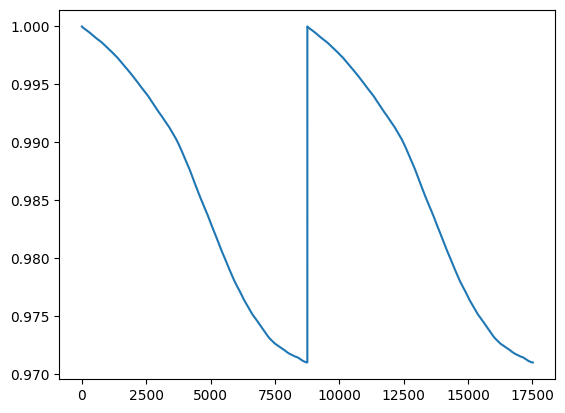

In [32]:
plt.plot(logs['only_market']['soh'][:int(len(logs['ppo']['soh'])/14)])